#Deep-COVID: Predicting COVID-19 From Chest X-Ray Images Using Deep Transfer Learning


# Step 1 - Preparation
This step setups a connection between the Colab server to the Google Drive server (authenticated by your Google account). By this way, you can synchronize the computational machine with your personal data.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Check GDrive connection
# NOTE: You should change this path based on your real configuration
#tutorial_path = '/content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/'
tutorial_path = '/content/drive/MyDrive/Cao hoc/Phan tich du lieu y khoa/Demo'

%cd '$tutorial_path'


[WinError 2] The system cannot find the file specified: "'$tutorial_path'"
d:\Google\Cao hoc\Phan tich du lieu y khoa\Demo


Next step, please install OpenCV version 3.4.2.17 (checked, not sure for other even new version)

In [5]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.2 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30

Test the installation progress is success or not.

In [6]:
%matplotlib inline
import sys
# Works in command line but for Jupyter including cv2 python env necessary. I guess it's part of python lib hell
import cv2
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import argparse

import sys
sys.argv=['']
del sys

In [8]:
parser = argparse.ArgumentParser(description='COVID-19 Detection from X-ray Images')
parser.add_argument('--batch_size', type=int, default=20, 
                    help='input batch size for training (default: 20)')
parser.add_argument('--epochs', type=int, default=100, 
                    help='number of epochs to train (default: 100)')
parser.add_argument('--num_workers', type=int, default=0, 
                    help='number of workers to train (default: 0)')
parser.add_argument('--learning_rate', type=float, default=0.0001, 
                    help='learning rate (default: 0.0001)')
parser.add_argument('--momentum', type=float, default=0.9, 
                    help='momentum (default: 0.9)')
parser.add_argument('--dataset_path', type=str, default='./data/',
                      help='training and validation dataset')

args = parser.parse_args()

start_time= time.time()

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


data_dir = args.dataset_path

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= args.batch_size,
                                             shuffle=True, num_workers= args.num_workers)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes  ## 0: child, and 1: nonchild


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [10]:
def imshow(inp, title= None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs= 20):
    since = time.time()
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                #print(cur_batch_ind,"batch inputs shape:", inputs.shape)
                #print(cur_batch_ind,"batch label shape:", labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc



def visualize_model(model, num_images= 64):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images/8, 8, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [11]:

#### load model
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= args.learning_rate, momentum= args.momentum)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, args.batch_size, num_epochs= args.epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet18_epoch%d.pt' %args.epochs )




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
95-th epoch, 3-th batch (size=20), val acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
95-th epoch, 4-th batch (size=20), val acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
95-th epoch, 5-th batch (size=20), val acc= 0.950 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       devic

In [12]:
#### Inference code for covid detection
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
import argparse
start_time= time.time()




parser = argparse.ArgumentParser(description='COVID-19 Detection from X-ray Images')
parser.add_argument('--test_covid_path', type=str, default='./data/test/covid/',
                      help='COVID-19 test samples directory')
parser.add_argument('--test_non_covid_path', type=str, default='./data/test/non/',
                      help='Non-COVID test samples directory')
parser.add_argument('--trained_model_path', type=str, default='./covid_resnet18_epoch100.pt',
                      help='The path and name of trained model')

parser.add_argument('--cut_off_threshold', type=float, default= 0.2, 
                    help='cut-off threshold. Any sample with probability higher than this is considered COVID-19 (default: 0.2)')
parser.add_argument('--batch_size', type=int, default=20, 
                    help='input batch size for training (default: 20)')
parser.add_argument('--num_workers', type=int, default=0, 
                    help='number of workers to train (default: 0)')


args = parser.parse_args()







In [13]:
############## Utility function to find sensitivity and specificity for different cut-off thresholds
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob >= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (noncovid_prob < thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




class_names = ['covid','non']




############### Test on trained model
model_name= args.trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()




############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

sm = torch.nn.Softmax()



############### Get the predicted probabilities of all samples
test_covid  = glob.glob("%s*" %args.test_covid_path)
test_non    = glob.glob("%s*" %args.test_non_covid_path)

covid_pred= np.zeros([len(test_covid),1]).astype(int)
non_pred  = np.zeros([len(test_non),1]).astype(int)

covid_prob= np.zeros([len(test_covid),1])
non_prob   = np.zeros([len(test_non),1])


for i in range(len(test_covid)):
    cur_img= image_loader(test_covid[i])
    model_output= model(cur_img)
    cur_pred = model_output.max(1, keepdim=True)[1]
    cur_prob = sm(model_output)
    covid_prob[i,:]= cur_prob.data.numpy()[0,0]
    print("%03d Covid predicted label:%s" %(i, class_names[int(cur_pred.data.numpy())]) )


for i in range(len(test_non)):
    cur_img= image_loader(test_non[i])
    model_output= model(cur_img)
    cur_pred = model_output.max(1, keepdim=True)[1]  
    cur_prob = sm(model_output)
    non_prob[i,:]= cur_prob.data.numpy()[0,0]
    print("%03d Non-Covid predicted label:%s" %(i, class_names[int(cur_pred.data.numpy())]) )



#pickle.dump( covid_prob, open( "./results/covid_prob_%s.p" %model_name, "wb" ) )
#pickle.dump( non_prob, open(   "./results/non_prob_%s.p" %model_name, "wb" ) )



############### find sensitivity and specificity
thresh= args.cut_off_threshold
sensitivity_40, specificity= find_sens_spec( covid_prob, non_prob, thresh)



############### derive labels based on probabilities and cut-off threshold
covid_pred = np.where( covid_prob  >thresh, 1, 0)
non_pred   = np.where( non_prob  >thresh,   1, 0)



############### derive confusion-matrix
covid_list= [int(covid_pred[i]) for i in range(len(covid_pred))]
covid_count = [(x, covid_list.count(x)) for x in set(covid_list)]

non_list= [int(non_pred[i]) for i in range(len(non_pred))]
non_count = [(x, non_list.count(x)) for x in set(non_list)]

y_pred_list= covid_list+non_list
y_test_list= [1 for i in range(len(covid_list))]+[0 for i in range(len(non_list))]

y_pred= np.asarray(y_pred_list, dtype=np.int64)
y_test= np.asarray(y_test_list, dtype=np.int64)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)   







__main__:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Covid predicted label:non
001 Covid predicted label:non
002 Covid predicted label:non
003 Covid predicted label:non
004 Covid predicted label:non
005 Covid predicted label:non
006 Covid predicted label:non
007 Covid predicted label:non
008 Covid predicted label:non
009 Covid predicted label:non
010 Covid predicted label:non
011 Covid predicted label:non
012 Covid predicted label:non
013 Covid predicted label:non
014 Covid predicted label:non
015 Covid predicted label:non
016 Covid predicted label:non
017 Covid predicted label:non
018 Covid predicted label:non
019 Covid predicted label:non
020 Covid predicted label:non
021 Covid predicted label:non
022 Covid predicted label:non
023 Covid predicted label:non
024 Covid predicted label:non
025 Covid predicted label:non
026 Covid predicted label:non
027 Covid predicted label:non
028 Covid predicted label:non
029 Covid predicted label:non
030 Covid predicted label:non
031 Covid predicted label:non
032 Covid predicted label:non
033 Covid 

__main__:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


000 Non-Covid predicted label:non
001 Non-Covid predicted label:non
002 Non-Covid predicted label:non
003 Non-Covid predicted label:non
004 Non-Covid predicted label:non
005 Non-Covid predicted label:non
006 Non-Covid predicted label:non
007 Non-Covid predicted label:non
008 Non-Covid predicted label:non
009 Non-Covid predicted label:non
010 Non-Covid predicted label:non
011 Non-Covid predicted label:non
012 Non-Covid predicted label:non
013 Non-Covid predicted label:non
014 Non-Covid predicted label:non
015 Non-Covid predicted label:non
016 Non-Covid predicted label:non
017 Non-Covid predicted label:non
018 Non-Covid predicted label:non
019 Non-Covid predicted label:non
020 Non-Covid predicted label:non
021 Non-Covid predicted label:non
022 Non-Covid predicted label:non
023 Non-Covid predicted label:non
024 Non-Covid predicted label:non
025 Non-Covid predicted label:non
026 Non-Covid predicted label:non
027 Non-Covid predicted label:non
028 Non-Covid predicted label:non
029 Non-Covid 

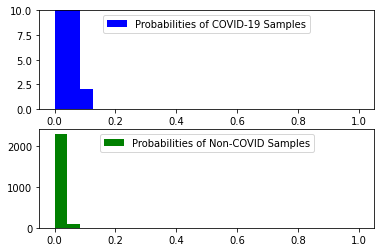

In [14]:

# Plot normalized confusion matrix
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])


ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019'])
ax.set_title("Confusion matrix")
plt.savefig('./confusion_matrix.png') #dpi = 200


############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('./scores_histogram.png') #dpi = 200






Total Time: 292.1431074142456


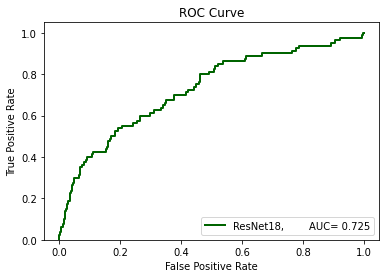

In [15]:

     
############### ROC Curve and AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



y_test_res18= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_prob))]
y_pred_res18= [covid_prob[i] for i in range(len(covid_prob))]+[non_prob[i] for i in range(len(non_prob))]

           
auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

plt.figure()
pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='darkgreen', linewidth=2,   label='ResNet18,        AUC= %.3f' %auc_res18)
pyplot.ylim([0,1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve")
# show the legend
pyplot.legend(loc='lower right')
plt.savefig('./ROC_covid19.png') #dpi = 200



end_time= time.time()
tot_time= end_time- start_time
print("\nTotal Time:", tot_time)